In [1]:
import os
import uproot
import numpy as np

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    with uproot.open(file_path) as file:
        tree = file["tree"]
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", tree.keys())
        # Each branch is added to the dictionary
        for branch in branches:
            try:
                all_branches[branch] = (tree[branch].array(library="np"))
            except uproot.KeyInFileError as e:
                print(f"KeyInFileError: {e}")
        # Number of events in file
        all_branches['event'] = tree.num_entries
    return all_branches

branches_list = [
    'sim_pT3_matched',
    'pT3_pt',
    'pT3_isFake',
    'pT3_isDuplicate',
    'pT3_eta',
    'pT3_phi',
    'pT3_score',
    'pT3_foundDuplicate',
    'pT3_matched_simIdx',
    'pT3_hitIdxs',
    'pT3_pixelRadius',
    'pT3_pixelRadiusError',
    'pT3_tripletRadius',
    'pT3_rPhiChiSquared',
    'pT3_rPhiChiSquaredInwards',
    'pT3_rzChiSquared',
    'pT3_layer_binary',
    'pT3_moduleType_binary'
]

file_path = "pt3_500_fixed_new_2.root"
branches = load_root_file(file_path, branches_list)

In [2]:
eta_max = 2.5
phi_max = np.pi

In [3]:
n_events = branches['event']

# Concatenate the pt3 branches over all events
pt3_rPhiChiSquared = np.concatenate([branches['pT3_rPhiChiSquared'][evt] for evt in range(n_events)])
pt3_rPhiChiSquaredInwards = np.concatenate([branches['pT3_rPhiChiSquaredInwards'][evt] for evt in range(n_events)])
pt3_rzChiSquared = np.concatenate([branches['pT3_rzChiSquared'][evt] for evt in range(n_events)])
pt3_eta = np.abs(np.concatenate([branches['pT3_eta'][evt] for evt in range(n_events)]))
pt3_trip_rad = np.abs(np.concatenate([branches['pT3_tripletRadius'][evt] for evt in range(n_events)]))
pt3_pix_rad = np.abs(np.concatenate([branches['pT3_pixelRadius'][evt] for evt in range(n_events)]))
pt3_pixRadError = np.abs(np.concatenate([branches['pT3_pixelRadiusError'][evt] for evt in range(n_events)]))

# Build the features array using the helper functions
features = np.array([
    np.log10(pt3_rPhiChiSquared),
    np.log10(pt3_trip_rad),
    np.log10(pt3_pix_rad),
    np.log10(pt3_pixRadError),
    np.log10(pt3_rzChiSquared),
    np.abs(pt3_eta)/eta_max
])

eta_list = np.array([pt3_eta])

In [4]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# ------------------ Preprocessing ------------------
input_features_numpy = np.stack(features, axis=-1)
mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)
filtered_input_features_numpy = input_features_numpy[np.all(mask, axis=1)]
t3_isFake_filtered = 1 - (np.concatenate(branches['pT3_isFake']))[np.all(mask, axis=1)]

# Convert to PyTorch tensors.
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)
labels_tensor = torch.tensor(t3_isFake_filtered, dtype=torch.float32).unsqueeze(1)

# ------------------ Device Setup ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------ Neural Network ------------------
class BinaryClassificationNeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassificationNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1)  # Single output for binary classification

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        return torch.sigmoid(x)  # Sigmoid activation for output between 0 and 1

# ------------------ Loss Function ------------------
class WeightedBinaryCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(WeightedBinaryCrossEntropyLoss, self).__init__()

    def forward(self, outputs, targets, weights):
        eps = 1e-7
        loss = -(targets * torch.log(outputs + eps) + (1 - targets) * torch.log(1 - outputs + eps))
        weighted_loss = loss * weights
        return weighted_loss.mean()

# ------------------ Class Weight Calculation ------------------
def calculate_binary_class_weights(labels):
    total_samples = len(labels)
    count_positive = labels.sum().item()
    count_negative = total_samples - count_positive
    weight_positive = total_samples / (2 * count_positive) if count_positive > 0 else 1.0
    weight_negative = total_samples / (2 * count_negative) if count_negative > 0 else 1.0
    
    sample_weights = torch.zeros(total_samples)
    for i in range(total_samples):
        if labels[i] == 1:
            sample_weights[i] = weight_positive
        else:
            sample_weights[i] = weight_negative
    return sample_weights

# ------------------ Data Preparation ------------------
print(f"Initial dataset size: {len(labels_tensor)}")

# Remove any rows with NaN in the input features (if any remain).
nan_mask = torch.isnan(input_features_tensor).any(dim=1)
filtered_inputs = input_features_tensor[~nan_mask]
filtered_labels = labels_tensor[~nan_mask]

# Print class distribution before downsampling.
num_real = filtered_labels.sum().item()          # label = 1 means real
num_fake = len(filtered_labels) - num_real         # label = 0 means fake
print(f"Class distribution before downsampling - Real: {num_real}, Fake: {num_fake}")

# Option to downsample the majority class.
downsample_classes = False
if downsample_classes:
    downsample_ratios = {1: 1.0, 0: 1.0}
    indices_list = []

    # Process real class (label 1).
    real_mask = (filtered_labels.squeeze() == 1)
    real_indices = torch.nonzero(real_mask).squeeze()
    num_real = real_indices.numel()
    num_real_to_sample = int(num_real * downsample_ratios[1])
    if num_real_to_sample < 1 and num_real > 0:
        num_real_to_sample = 1
    real_indices_shuffled = real_indices[torch.randperm(num_real)]
    sampled_real_indices = real_indices_shuffled[:num_real_to_sample]
    indices_list.append(sampled_real_indices)

    # Process fake class (label 0).
    fake_mask = (filtered_labels.squeeze() == 0)
    fake_indices = torch.nonzero(fake_mask).squeeze()
    num_fake = fake_indices.numel()
    num_fake_to_sample = int(num_fake * downsample_ratios[0])
    if num_fake_to_sample < 1 and num_fake > 0:
        num_fake_to_sample = 1
    fake_indices_shuffled = fake_indices[torch.randperm(num_fake)]
    sampled_fake_indices = fake_indices_shuffled[:num_fake_to_sample]
    indices_list.append(sampled_fake_indices)

    # Combine indices from both classes.
    selected_indices = torch.cat(indices_list)
    filtered_inputs = filtered_inputs[selected_indices]
    filtered_labels = filtered_labels[selected_indices]

# Print class distribution after downsampling.
num_real_after = filtered_labels.sum().item()
num_fake_after = len(filtered_labels) - num_real_after
print(f"Class distribution after downsampling - Real: {num_real_after}, Fake: {num_fake_after}")

# Calculate sample weights after downsampling.
sample_weights = calculate_binary_class_weights(filtered_labels)
filtered_weights = sample_weights

# Create the dataset.
dataset = TensorDataset(filtered_inputs, filtered_labels, filtered_weights)

# Split into train and test sets.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders.
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=10, pin_memory=True)

# ------------------ Model, Loss, and Optimizer ------------------
input_dim = filtered_inputs.shape[1]
model = BinaryClassificationNeuralNetwork(input_dim).to(device)
loss_function = WeightedBinaryCrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0025)

def evaluate_loss(loader):
    model.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for inputs, targets, weights in loader:
            inputs, targets, weights = inputs.to(device), targets.to(device), weights.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets, weights)
            total_loss += loss.item()
            num_batches += 1
    return total_loss / num_batches

# ------------------ Training Loop ------------------
num_epochs = 200
train_loss_log = []
test_loss_log = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    num_batches = 0

    for inputs, targets, weights in train_loader:
        inputs, targets, weights = inputs.to(device), targets.to(device), weights.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, targets, weights)
        epoch_loss += loss.item()
        num_batches += 1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss = epoch_loss / num_batches
    test_loss = evaluate_loss(test_loader)
    train_loss_log.append(train_loss)
    test_loss_log.append(test_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Using device: cuda
Initial dataset size: 229144
Class distribution before downsampling - Real: 192431.0, Fake: 36713.0
Class distribution after downsampling - Real: 192431.0, Fake: 36713.0
Epoch [1/200], Train Loss: 0.2689, Test Loss: 0.2072
Epoch [2/200], Train Loss: 0.1906, Test Loss: 0.1789
Epoch [3/200], Train Loss: 0.1737, Test Loss: 0.1718
Epoch [4/200], Train Loss: 0.1693, Test Loss: 0.1684
Epoch [5/200], Train Loss: 0.1665, Test Loss: 0.1673
Epoch [6/200], Train Loss: 0.1653, Test Loss: 0.1661
Epoch [7/200], Train Loss: 0.1661, Test Loss: 0.1631
Epoch [8/200], Train Loss: 0.1633, Test Loss: 0.1639
Epoch [9/200], Train Loss: 0.1628, Test Loss: 0.1792
Epoch [10/200], Train Loss: 0.1621, Test Loss: 0.1624
Epoch [11/200], Train Loss: 0.1610, Test Loss: 0.1613
Epoch [12/200], Train Loss: 0.1609, Test Loss: 0.1631
Epoch [13/200], Train Loss: 0.1617, Test Loss: 0.1628
Epoch [14/200], Train Loss: 0.1607, Test Loss: 0.1597
Epoch [15/200], Train Loss: 0.1595, Test Loss: 0.1610
Epoch [16/

In [5]:
from sklearn.metrics import accuracy_score

# Convert tensors to numpy for simplicity in permutation
input_features_np = input_features_tensor.numpy()
labels_np = labels_tensor.numpy()

def model_accuracy(features, labels, model):
    # Move the model to CPU for evaluation
    model.cpu()
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        # Ensure features and labels are on CPU
        inputs = features.to('cpu')
        labels = labels.to('cpu')
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()  # Update threshold as necessary
        accuracy = (predicted == labels).float().mean().item()
    return accuracy

# Use the original input_features_tensor and labels_tensor directly
baseline_accuracy = model_accuracy(input_features_tensor, labels_tensor, model)
print(f"Baseline accuracy: {baseline_accuracy}")

# Initialize an array to store feature importances
feature_importances = np.zeros(input_features_tensor.shape[1])

# Permute each feature and calculate the drop in accuracy
for i in range(input_features_tensor.shape[1]):
    permuted_features = input_features_tensor.clone()
    permuted_features[:, i] = permuted_features[torch.randperm(permuted_features.size(0)), i]  # Permute feature

    permuted_accuracy = model_accuracy(permuted_features, labels_tensor, model)
    feature_importances[i] = baseline_accuracy - permuted_accuracy

# Ranking features by importance
important_features_indices = np.argsort(feature_importances)[::-1]  # Indices of features in descending importance
important_features_scores = np.sort(feature_importances)[::-1]  # Importance scores in descending order

print("Feature importances:")
for idx, score in zip(important_features_indices, important_features_scores):
    print(f"Feature {idx} importance: {score:.4f}")

Baseline accuracy: 0.7410224080085754
Feature importances:
Feature 2 importance: 0.1705
Feature 1 importance: 0.1614
Feature 3 importance: 0.0985
Feature 5 importance: 0.0871
Feature 4 importance: 0.0293
Feature 0 importance: 0.0219


In [6]:
def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()

    # Print weights
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()

def print_model_weights_biases(model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Iterate through all named modules in the model
    for name, module in model.named_modules():
        # Check if the module is a linear layer
        if isinstance(module, nn.Linear):
            # Get weights and biases
            weights = module.weight.data.cpu().numpy()
            biases = module.bias.data.cpu().numpy()

            # Print formatted weights and biases
            print_formatted_weights_biases(weights, biases, name.replace('.', '_'))

print_model_weights_biases(model)


ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_layer1[32] = {
-1.0316417f, -0.5292138f, -1.3838978f, -0.7517025f, -0.8418103f, 0.8087351f, -0.1664009f, 0.2809185f, 1.3140178f, 0.7565588f, 0.0890440f, -0.4908848f, 0.4201532f, -0.4334770f, 0.5002150f, -0.5591785f, 1.2298888f, 0.0346711f, -0.4166603f, -0.0064792f, -0.2969901f, -0.3028315f, 0.0721094f, 0.2584246f, -0.2035742f, -0.2888707f, -0.1322349f, 0.5589037f, 0.4285649f, 0.1511498f, 0.1774099f, -0.9249431f };

ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_layer1[6][32] = {
{ -0.2303199f, -0.0356287f, 0.1646899f, -0.1455843f, -0.0290584f, 0.2789465f, 0.0559607f, -0.2009920f, -0.0174202f, -0.0237667f, 0.1854273f, -0.0269862f, -0.0826555f, 0.7338054f, 0.0937388f, -0.8827202f, -0.0182344f, 0.0352709f, -0.1331034f, -0.0432344f, 0.0208153f, -0.1124316f, 0.1652907f, -0.1187222f, -0.0506563f, 0.2842667f, -0.7510378f, 0.0503595f, -0.0329987f, -0.8018139f, -0.0368841f, -0.0285996f },
{ 0.7176192f, -0.1105556f, 0.8051441f, -0.4914712f, -0.0188390

/tmp/ipykernel_1882258/1646812576.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to('cpu')


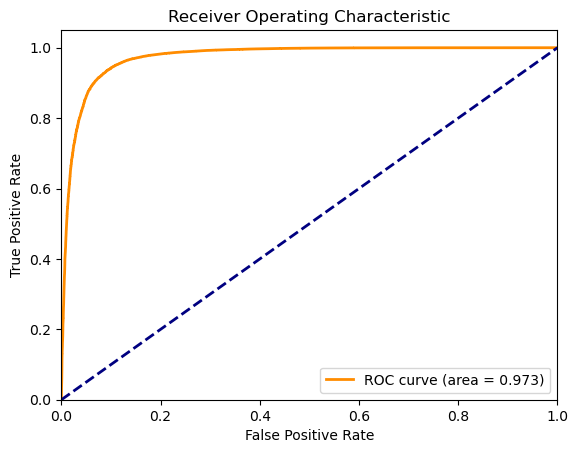

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def model_outputs(features, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        inputs = torch.tensor(features, dtype=torch.float32).to('cpu')
        outputs = model(inputs).squeeze().cpu().numpy()
    return outputs

# Calculate model outputs
probabilities = model_outputs(filtered_inputs, model)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(filtered_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [8]:
# Ensure input_features_tensor is moved to the appropriate device
input_features_tensor = input_features_tensor.to('cpu')

# Make predictions
with torch.no_grad():
    model.eval()
    outputs = model(input_features_tensor)
    predictions = outputs.squeeze().cpu().numpy()

full_tracks = (np.concatenate(branches['pT3_isFake']) == 0)

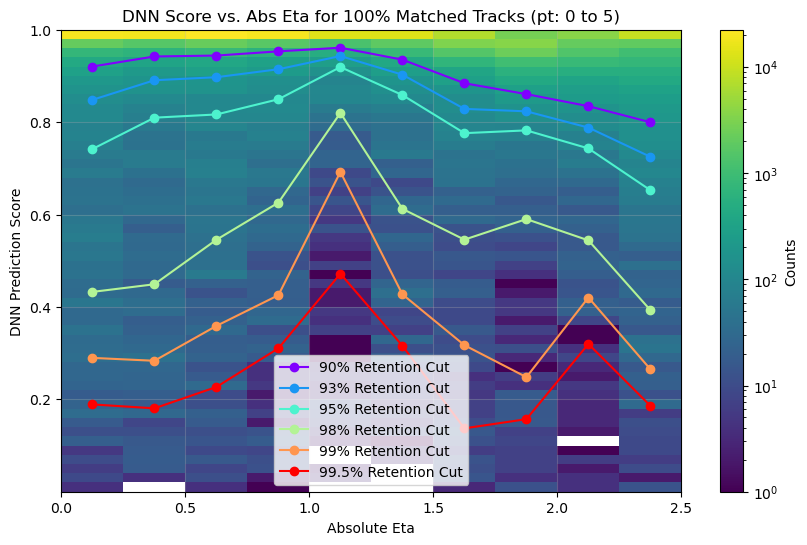


pt: 0 to 5
90% Retention Cut: {0.9204, 0.9421, 0.9441, 0.9532, 0.961, 0.9352, 0.8842, 0.8606, 0.8345, 0.7997} Mean: 0.9035
93% Retention Cut: {0.8482, 0.8907, 0.8972, 0.9145, 0.943, 0.9027, 0.8286, 0.8234, 0.7881, 0.7249} Mean: 0.8561
95% Retention Cut: {0.7417, 0.8096, 0.8166, 0.8495, 0.9192, 0.8586, 0.7761, 0.7821, 0.7431, 0.6526} Mean: 0.7949
98% Retention Cut: {0.4325, 0.449, 0.5454, 0.6257, 0.8199, 0.6123, 0.5456, 0.5901, 0.5441, 0.393} Mean: 0.5558
99% Retention Cut: {0.2897, 0.2835, 0.3589, 0.4254, 0.6923, 0.4273, 0.3172, 0.248, 0.4203, 0.2651} Mean: 0.3728
99.5% Retention Cut: {0.189, 0.1805, 0.2267, 0.3104, 0.4719, 0.3159, 0.1372, 0.1571, 0.3198, 0.186} Mean: 0.2495


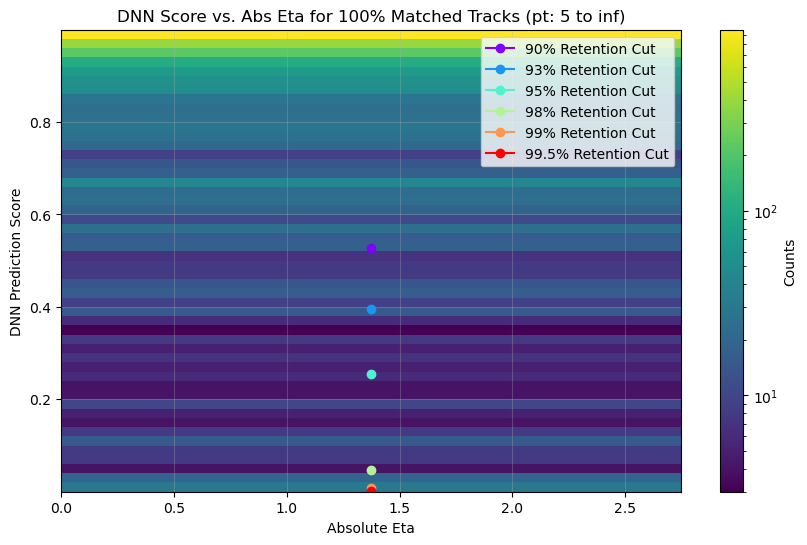


pt: 5 to inf
90% Retention Cut: {0.5279} Mean: 0.5279
93% Retention Cut: {0.3964} Mean: 0.3964
95% Retention Cut: {0.2557} Mean: 0.2557
98% Retention Cut: {0.0473} Mean: 0.0473
99% Retention Cut: {0.0091} Mean: 0.0091
99.5% Retention Cut: {0.0024} Mean: 0.0024


In [11]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

def plot_for_pt_bin(pt_min, pt_max, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Calculate and plot cut values for specified percentiles in a given pt bin
    
    Parameters:
    -----------
    pt_min : float
        Minimum pt value for the bin
    pt_max : float
        Maximum pt value for the bin
    percentiles : list
        List of percentiles to calculate (e.g., [92.5, 96.7, 99])
    eta_bin_edges : array
        Edges of the eta bins
    eta_list : list
        List of eta values
    predictions : array
        Array of DNN predictions
    full_tracks : array
        Boolean array for track selection
    branches : dict
        Dictionary containing branch data
    """
    # Filter data based on pt bin
    abs_eta = eta_list[0][full_tracks & (np.concatenate(branches['pT3_pt']) > pt_min) & 
                         (np.concatenate(branches['pT3_pt']) <= pt_max)]
    predictions_filtered = predictions[full_tracks & (np.concatenate(branches['pT3_pt']) > pt_min) & 
                                    (np.concatenate(branches['pT3_pt']) <= pt_max)]
    
    # Dictionary to store cut values for different percentiles
    cut_values = {p: [] for p in percentiles}

    # Loop through each eta bin
    for i in range(len(eta_bin_edges) - 1):
        # Get indices of tracks within the current eta bin
        bin_indices = (abs_eta >= eta_bin_edges[i]) & (abs_eta < eta_bin_edges[i + 1])
        
        # Get the corresponding DNN prediction scores
        bin_predictions = predictions_filtered[bin_indices]
        
        # Calculate the percentile cut values for the current bin
        for percentile in percentiles:
            cut_value = np.percentile(bin_predictions, 100 - percentile)  # Convert retention to percentile
            cut_values[percentile].append(cut_value)

    # Plot 2D histogram
    plt.figure(figsize=(10, 6))
    plt.hist2d(abs_eta, predictions_filtered, bins=[eta_bin_edges, 50], norm=LogNorm())
    plt.colorbar(label='Counts')
    plt.xlabel("Absolute Eta")
    plt.ylabel("DNN Prediction Score")
    plt.title(f"DNN Score vs. Abs Eta for 100% Matched Tracks (pt: {pt_min} to {pt_max})")

    # Plot the cut values with different colors
    cut_x = eta_bin_edges[:-1] + (eta_bin_edges[1] - eta_bin_edges[0]) / 2  # Mid-points of the bins
    colors = plt.cm.rainbow(np.linspace(0, 1, len(percentiles)))  # Generate distinct colors
    
    for percentile, color in zip(percentiles, colors):
        plt.plot(cut_x, cut_values[percentile], '-', color=color, marker='o', 
                label=f'{percentile}% Retention Cut')
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print the cut values
    print(f"\npt: {pt_min} to {pt_max}")
    for percentile in percentiles:
        values = cut_values[percentile]
        print(f"{percentile}% Retention Cut:", 
              '{' + ', '.join(str(x) for x in np.round(values, 4)) + '}',
              "Mean:", np.round(np.mean(values), 4))

# Example usage:
def analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Analyze and plot for multiple pt bins and percentiles
    
    Parameters:
    -----------
    pt_bins : list
        List of pt bin edges
    percentiles : list
        List of percentiles to calculate
    Other parameters same as plot_for_pt_bin function
    """
    for i in range(len(pt_bins) - 1):
        plot_for_pt_bin(pt_bins[i], pt_bins[i + 1], percentiles, eta_bin_edges, 
                       eta_list, predictions, full_tracks, branches)

percentiles = [90, 93, 95, 98, 99, 99.5]

# For pt <= 5 using multiple eta bins
pt_bins_low = [0, 5]
analyze_pt_bins(pt_bins_low, percentiles, np.arange(0, 2.75, 0.25), eta_list, predictions, full_tracks, branches)

# For pt > 5 using a single eta bin
pt_bins_high = [5, np.inf]
single_eta_bin = np.array([0, 2.75])
analyze_pt_bins(pt_bins_high, percentiles, single_eta_bin, eta_list, predictions, full_tracks, branches)